In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Oxford pet Dataset 소개

인공지능 프로젝트를 개발하는 데 가장 중요한 것은 우선 데이터를 찾고 전처리하는 작업이다.

### 2 Oxford pet Dataset 코드 읽어 오기

코랩 서버에 데이터를 업로드하고 데이터 세트에 대한 시각화 및 정보를 출력해 보자.

1. 데이터 다운로드 및 압축 풀기

In [ ]:
# !sudo apt-get install unzip

In [ ]:
import gdown
url = 'https://drive.google.com/file/d/1USSTL8IlR_gux_FAPFI4wpOkEdanxgPZ'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)
!unzip -qq /content/drive/MyDrive/oxford_pet.zip

In [2]:
!unzip /content/drive/MyDrive/oxford_pet.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/Persian_187.jpg  
  inflating: /content/images/boxer_126.jpg  
  inflating: /content/images/saint_bernard_178.jpg  
  inflating: /content/images/havanese_189.jpg  
  inflating: /content/images/keeshond_123.jpg  
  inflating: /content/images/english_cocker_spaniel_112.jpg  
  inflating: /content/images/pomeranian_174.jpg  
  inflating: /content/images/american_pit_bull_terrier_112.jpg  
  inflating: /content/images/Sphynx_23.jpg  
  inflating: /content/images/havanese_8.jpg  
  inflating: /content/images/pomeranian_43.jpg  
  inflating: /content/images/Bombay_30.jpg  
  inflating: /content/images/english_cocker_spaniel_42.jpg  
  inflating: /content/images/boxer_28.jpg  
  inflating: /content/images/Bengal_68.jpg  
  inflating: /content/images/american_bulldog_39.jpg  
  inflating: /content/images/keeshond_33.jpg  
  inflating: /content/images/leonberger_192.jpg  
  inflating: /content/images/leonberger_58.j

2. 라이브러리 import하기

pandas, seaborn, matplotlib.pyplot을 import한다.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

3. list.txt파일 읽어 오기

images, annotations 폴더를 업로드하고 데이터 정보가 있는 list,txt 파일을 읽어온다.

In [4]:
df = pd.read_csv('./annotations/list.txt', skiprows=6, delimiter=' ', header=None)

# list.txt 안의 정보대로 파일 이름, id, species, breed 순서로 칼럼을 만들어 준다.
df.columns = ['file_name', 'id', 'species', 'breed']
df

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [5]:
# 고양이와 강아지의 정보 출력하기
print(df['species'].value_counts().sort_index())

species
1    2371
2    4978
Name: count, dtype: int64


4. 그래프로 시각화하기

개인지 고양이인지 구분해 주는 species 속성을 바 그래프로 불러와 개수를 시각화한다.

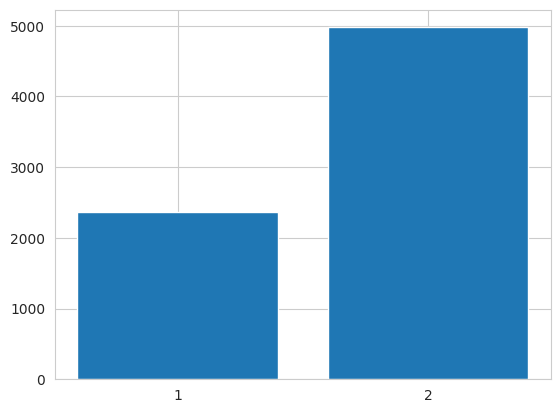

In [6]:
value_counts = df['species'].value_counts().sort_index()

plt.bar(range(len(value_counts)), value_counts.values, align='center')
plt.xticks(range(len(value_counts)), value_counts.index.values)

plt.show()

5. 다른 파일 읽어 오기 및 경로 설정하기

앞서 설명한 파일들의 경로를 읽어서 파일을 잘 읽어 왔는지 확인한다.

In [9]:
import os
from glob import glob

image_dir = os.path.join('/content/images')
bbox_dir = os.path.join('/content/annotations/xmls')
seg_dir = os.path.join('/content/annotations/trimaps')

image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
len(image_files)

7390

In [14]:
# 파일 확인
image_files[:10]

['yorkshire_terrier_86.jpg',
 'japanese_chin_137.jpg',
 'american_pit_bull_terrier_140.jpg',
 'newfoundland_82.jpg',
 'wheaten_terrier_166.jpg',
 'Egyptian_Mau_181.jpg',
 'Russian_Blue_194.jpg',
 'scottish_terrier_4.jpg',
 'staffordshire_bull_terrier_74.jpg',
 'Maine_Coon_193.jpg']

In [12]:
seg_files = glob(seg_dir + '*.png')
len(seg_files)

0

In [13]:
bbox_files = glob(bbox_dir + '*.xml')
len(bbox_files)

0

### 3 head ROI 읽어 오기

개와 고양이 이미지에 바운딩 박스를 표시하고, 개, 고양이 부분과 배경 부부을 색으로 구분해 보자.

1. 라이브러리 import하기

이미지를 읽기 위한 라이브러리와 바운딩 박스를 그리기 위한 라이브러리 및 xml을 다루기 위한 라이브러리를 가져온다.

In [15]:
import cv2
import xml.etree.ElementTree as et
from matplotlib.patches import Rectangle

2. 바운딩 박스 **그리기**

In [ ]:
image_path = image_files[110]
# 저장된 위치를 달리해 불러온다.
bbox_path = image_path.replace(image_dir, bbox_dir).replace('jgp', 'xml')

image = cv2.imread(image_path)

# BGR 형식을 RGB로 바꾼다.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# xml 파일을 가져와 준다.
tree = et.parse(bbox_path)

# 바운딩 박스의 좌표를 가져와 읽어 온다.
xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

# 바운딩 박스를 그린다.
rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.axes().add_patch(rect)
plt.imshow(image)

plt.show()

In [16]:
import cv2
import xml.etree.ElementTree as et
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt # Import matplotlib.pyplot

image_path = image_files[110]
# 저장된 위치를 달리해 불러온다.
bbox_path = image_path.replace(image_dir, bbox_dir).replace('jpg', 'xml')

image = cv2.imread(image_path)

# Check if the image was loaded successfully.
if image is None:
    print(f"Error: Could not load image from {image_path}. Check the file path and permissions.")
else:
    # BGR 형식을 RGB로 바꾼다.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # xml 파일을 가져와 준다.
    tree = et.parse(bbox_path)

    # 바운딩 박스의 좌표를 가져와 읽어 온다.
    xmin = float(tree.find('./object/bndbox/xmin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)

    # 바운딩 박스를 그린다.
    rect_x = xmin
    rect_y = ymin
    rect_w = xmax - xmin
    rect_h = ymax - ymin

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')

    # Create a figure and axes if they don't exist
    if not plt.gca():
        fig, ax = plt.subplots()
    else:
        ax = plt.gca()

    ax.add_patch(rect)
    plt.imshow(image)

    plt.show()

Error: Could not load image from american_bulldog_11.jpg. Check the file path and permissions.


3. segmap 정보 시각화하기

개와 고양이의 구분은 검은색으로, 배경은 빨간색으로, 그 외는 하얀색으로 표현된다.

In [17]:
image_path = image_files[110]
# 확장자를 jpg에서 png로 변경한다.
seg_path = image_path.replace(image_dir, seg_dir).replace('jpg', 'png')
# 이미지 읽기
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# seg_amp 정보는 일반 이미지와 달리 GRAYSCALE을 사용하여 읽어 와야 한다.
seg_map = cv2.imgread(seg_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(seg_map)

plt.show()

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [18]:
image_path = image_files[110]
# 확장자를 jpg에서 png로 변경한다.
seg_path = image_path.replace(image_dir, seg_dir).replace('jpg', 'png')
# 이미지 읽기
image = cv2.imread(image_path)

# Check if image loaded successfully
if image is None:
    print(f"Error: Could not load image from {image_path}. Check the file path and permissions.")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # seg_amp 정보는 일반 이미지와 달리 GRAYSCALE을 사용하여 읽어 와야 한다.
    seg_map = cv2.imgread(seg_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(seg_map)

    plt.show()

Error: Could not load image from american_bulldog_11.jpg. Check the file path and permissions.


### 4 KFold 이미지 분류하기

교차 검증을 위해 데이터를 5개의 세트로 나누어 보자.

1. 훈련 데이터와 검증 데이터 나누기

이미지 데이터를 훈련 데이터와 검증 데이터로 나누고 개수를 확인한다.

<aside>
💡 교차 검증을 위해 KFold를 가져온다.   
품종을 균등하게 분포하기 위해 StratifiedKFold를 가져온다.   
데이터를 나눠 준다.   
훈련 데이터와 검증 데이터의 개수를 확인할 수 있다.  

</aside>

1. 데이터 확인 및 저장하기

데이터 비율을 시각화하여 확인한다.

In [19]:
value_counts = df[df['fold'] != 5]['id'].value_counts().sort_index()

plt.bar(range(len(value_counts)), value_counts.values, align='center')
plt.xticks(range(len(value_counts)), value_counts.index.values)

plt.tight_layout()
plt.show()

df.to_csv('./kfolds.csv', index=False)

KeyError: 'fold'

In [20]:
# Check if 'fold' column exists in the DataFrame
if 'fold' in df.columns:
    value_counts = df[df['fold'] != 5]['id'].value_counts().sort_index()

    plt.bar(range(len(value_counts)), value_counts.values, align='center')
    plt.xticks(range(len(value_counts)), value_counts.index.values)

    plt.tight_layout()
    plt.show()

    df.to_csv('./kfolds.csv', index=False)
else:
    print("Error: 'fold' column not found in the DataFrame.")
    # Investigate why the 'fold' column is missing and add it to the DataFrame

Error: 'fold' column not found in the DataFrame.


해당 이미지가 균등하게 뽑혔는지 확인한다.
해당 파일을 csv 파일로 저장한다.